## Some Useful ffmpeg resources
https://trac.ffmpeg.org/wiki/How%20to%20speed%20up%20/%20slow%20down%20a%20video

In [6]:
import sys

import argparse
import logging
from os.path import join
logger = logging.getLogger(__name__)
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import scipy.linalg as LA
import matplotlib.pyplot as plt
sys.path.append("../scripts")

from gmm.gmm import GMM
from cost import Cost
from config import Vxf0, options, ds_options
from stabilizer.traj_stab import stabilizer
from utils.utils import guess_init_lyap
from utils.dataloader import load_saved_mat_file
from utils.gen_utils import *
from visualization.visualizer import Visualizer
from stabilizer.correct_trajos import CorrectTrajectories, check_options


In [7]:
def load_saved_mat_file(x, **kwargs):
    matFile = sio.loadmat(x)

    data = matFile['Data']
    demoIdx = matFile['demoIndices']
    demoIdx -= 1

    if ('Priors_EM' or 'Mu_EM' or 'Sigma_EM') in kwargs:
        Priors_EM, Mu_EM, Sigma_EM = matFile['Priors_EM'], matFile['Mu_EM'], matFile['Sigma_EM']
        return data, demoIdx, Priors_EM, Mu_EM, Sigma_EM
    else:
        return data, demoIdx

data_args = {'Priors_EM': None}
models = {'w': 'w.mat', 's': 'Sshape.mat'}
data, demoIdx = load_saved_mat_file(join('../scripts/data', models['s']))

Vxf0['d'] = data.shape[0]//2
Vxf0.update(Vxf0)

Vxf0 = guess_init_lyap(data, Vxf0, options['int_lyap_random'])
cost = Cost(nDemo = 1, success=True, Nfeval = 0, verbose=False)

In [8]:
while cost.success:
    print('Optimizing the lyapunov function')
    Vxf, J = cost.learnEnergy(Vxf0, data, options)
    old_l = Vxf0['L']
    Vxf0['L'] += 1
    print('Constraints violated. increasing the size of L from {} --> {}'.format(old_l, Vxf0['L']))
    if cost.success:
        print('optimization succeeded without violating constraints')
        break

Optimizing the lyapunov function
Constraints violated. increasing the size of L from 3 --> 4
optimization succeeded without violating constraints


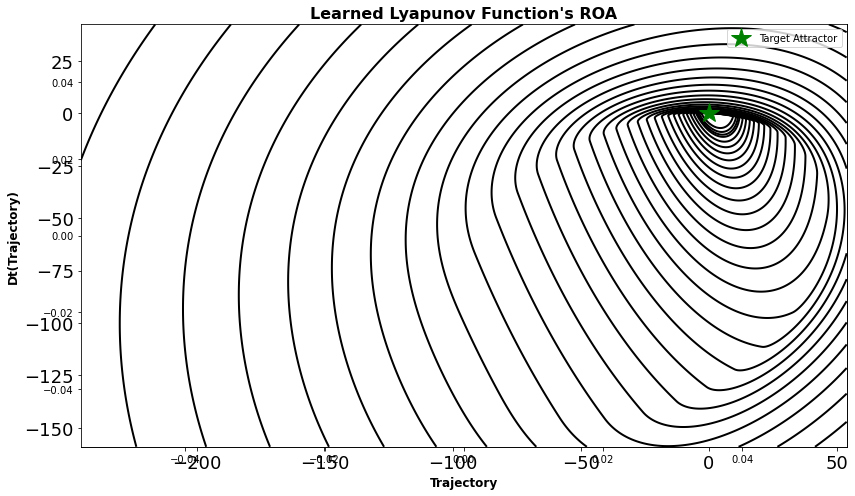

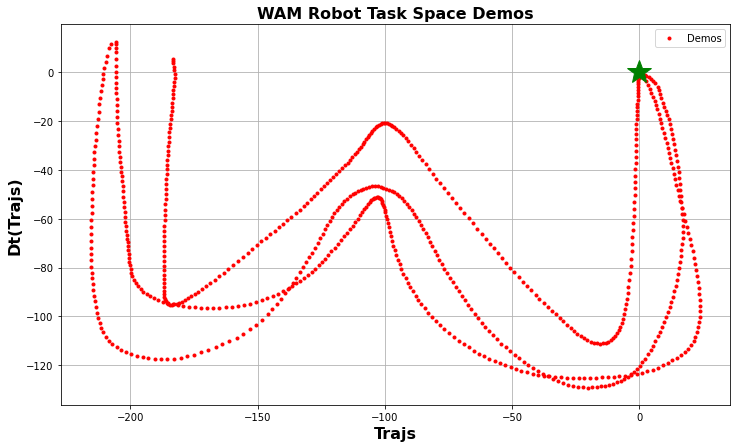

In [4]:
fontdict = {'fontsize':16, 'fontweight':'bold'}
# https://matplotlib.org/stable/users/interactive.html
plt.ion()

# fig = plt.figure(figsize=(12, 7))

savedict = dict(save=True, savename='demos_s.jpg',\
                savepath=join("..", "scripts/docs"))
viz = Visualizer(winsize=(12, 7), savedict=savedict, data=data,
                labels=['Trajs', 'Dt(Trajs)']*2, alphas = [.15]*4,
                fontdict=fontdict)

level_args = dict(disp=True, levels = [], save=True)
viz.init_demos(save=True)
# Optimize and plot the level sets of the Lyapunov function
viz.savedict["savename"]="level_sets_s.jpg"
handles = viz.level_sets(Vxf, cost, **level_args)
viz.draw()

In [44]:
rho0 = 1.0
kappa0 = 0.1

traj = list(range(Vxf['d']))
traj_derivs = np.arange(Vxf['d'], 2 * Vxf['d'])
mu, sigma, priors = Mu_EM, Sigma_EM, Priors_EM

In [41]:
# gmm = GMM(num_clusters=options['num_clusters'])
# gmm.update(data.T, K=options['num_clusters'], max_iterations=100)
# mu, sigma, priors = gmm.mu.T, gmm.sigma.T, gmm.logmass.T

In [50]:

Xinit = data[:Vxf['d'], demoIdx[0, :-1]]
gmr_args = {'time_varying': False}
gmr_handle = lambda x: GMR(priors, mu, sigma, x, traj, traj_derivs, **gmr_args)
stab_handle = lambda x: stabilizer(x, gmr_handle, Vxf, rho0, kappa0) 

In [51]:
Priors_EM

array([[0.20218997, 0.20562152, 0.18374347, 0.18494871, 0.22349632]])

In [48]:
Xinit = data[:Vxf['d'], demoIdx[0, :-1]]
Xinit#.shape

array([[-183.09859155, -207.51173709, -205.63380282],
       [   5.34521158,   11.58129176,   12.47216036]])

In [12]:
x, xdot, _, _, _ = CorrectTrajectories(Xinit, [], stab_handle, Bundle(ds_options))

x: (2, 1, 3) XT: (3, 3)


ValueError: operands could not be broadcast together with shapes (2,3) (3,3) 

<Figure size 864x504 with 0 Axes>

KeyboardInterrupt: 

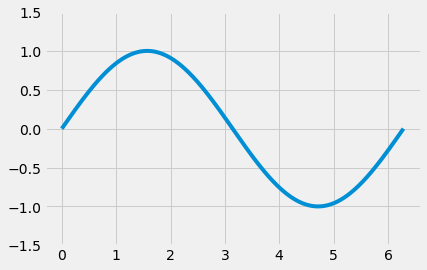

In [91]:
plt.ion()

fig, ax = plt.subplots()
th = np.linspace(0, 2*np.pi, 512)
ax.set_ylim(-1.5, 1.5)

ln, = ax.plot(th, np.sin(th))

def slow_loop(N, ln):
    for j in range(N):
        time.sleep(.1)  # to simulate some work
        ln.figure.canvas.flush_events()

slow_loop(100, ln)

In [21]:
x = np.empty((2,1))
xx = np.tile(x, [1, 3])
print(xx.shape)
np.squeeze(xx[:,0,:])

(2, 3)


IndexError: too many indices for array

In [31]:
XT = np.array(([[1, 2, 3]])).T
XT = np.tile(XT, [1, 2])
XT.shape, XT

((3, 2),
 array([[1, 1],
        [2, 2],
        [3, 3]]))

# "Now stabilize the learned dynamics"
opt_sim = {'dt': 0.01,  'i_max': 4000, 'tol': 1}
d = data.shape[0]//2  # dimension of data
X0 = data[:d, demoIdx[0, :-1] - 1]

In [127]:
x = [2]
for i in range(5):
    x.append(i)
x    

[2, 0, 1, 2, 3, 4]

In [138]:
X0 = np.ones((2, 3))
x = np.zeros((4000,)+(X0.shape))
x[0] = X0

(2, 3) (4000, 2, 3)


In [131]:
x[0]

array([[1., 1., 1.],
       [1., 1., 1.]])

In [124]:
kwargs = {'Priors_EM': None}
data, demoIdx, Priors_EM, Mu_EM, Sigma_EM = load_saved_mat_file(join('../example_models/', modelNames[modelNumber]), **kwargs)


In [125]:
Priors_EM

array([[0.20218997, 0.20562152, 0.18374347, 0.18494871, 0.22349632]])